In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import sqlite3
%matplotlib inline

## Perform query on SQLite database

In [2]:
conn = sqlite3.connect("/home/luciano/python/load_profiling/dataport")
cursor = conn.cursor()
query = "SELECT * FROM new_table;"
cursor.execute(query)
data = cursor.fetchall()

## Load result into a pandas Dataframe 

In [3]:
df = pd.DataFrame(data, columns=['id','date','energy_use'])
df.head() 
# id is the id of the house in the study and energy_use in the amount of energy consumed during a 15 minute interval

,id,date,energy_use
0,26,2015-08-01 00:00:00,1.4090666666666667
1,26,2015-07-31 23:45:00,3.1387333333333333
2,26,2015-07-31 23:30:00,4.2021333333333333
3,26,2015-07-31 23:15:00,4.2418000000000000
4,26,2015-07-31 23:00:00,4.2857333333333333


## Data wrangling

### Count the amount of missing  values

In [102]:
def count_empty_strings(data):
    """returns the percentage of empty strings in a dataframe column"""
    empty = 0
    not_empty=0
    
    for row in data:
        if row == "":
            empty += 1
        else:
            not_empty += 1
            
    print("there are",str(round(empty/not_empty*100))+"%","of missing values")

In [103]:
count_empty_strings(df.energy_use)

there are 2% of missing values


### Filter out empty strings 

In [105]:
df2 = df[df['energy_use']!=""]
count_empty_strings(df2.energy_use) # how many empty values do we have now?

there are 0% of missing values


### Trasform data types

In [106]:
df2 = df2.copy()
df2.loc[:,'energy_use'] = df2.energy_use.astype(float) # transfrom load consumption values into into float

df2.loc[:,'date'] = pd.to_datetime(df2.date) # transforms date column into datetime
df2.dtypes

id                    object
date          datetime64[ns]
energy_use           float64
dtype: object

### Create columns with information about the date of the measurement 

This will be usefull later

In [8]:
# create a column that contains info if the observation is on a weekday or a weekend
df2['type_day'] = df2.date.apply(lambda x: x.isoweekday()) 

# create a column of the day of the month for a particular observation
df2['day_of_month'] = df2.date.apply(lambda x: x.day) 

# create a column of the month of the year for a particular observation
df2['month'] = df2.date.apply(lambda x: x.month) 

# sort values 
df2.sort_values(['id', 'date'], ascending=[True, True],inplace=True)

df2.reset_index(inplace=True)

### Filter out the weekends

In [10]:
df3 = df2[(df2['type_day'] != 6) & (df2['type_day'] != 7)] # select only weekdays

df3 = df3.copy()
# transfrom id column to integer
df3.loc[:,'id'] = df3['id'].astype(int) 

###  How many different housholds in the dataset

In [108]:
households = np.unique(df3['id'])   
print("there are",np.count_nonzero(households),"different households") 

there are 216 different households


###  Create function to extract daily loads from the time-series

In [31]:
def extract_daily_load():
     """parses the time-series to extract load measurements from one particular day for one particular house"""

    load_data =[]
    for house in households:
        data_one_house = df3[df3['id'] == house]

        for month in range(7,8):
            for day in range(1,31):

                one_day_load = (data_one_house[data_one_house['month'] == month]
                                [data_one_house['day_of_month'] == day])
                if len(one_day_load) == 96: # only grab daily loads with 96 observations
                    load_data.append(one_day_load.energy_use)

    return load_data

In [111]:
load_data = extract_daily_load()

### Transform list of lists into numpy array 

In [114]:
load_data_np = np.array(load_data) # transform list of lists into numpy array

print("There are",load_data_np.shape[0],"day-loads in the dataset. Each containing",
      load_data_np.shape[1] ,"load measurements.")

There are 4702 day-loads in the dataset. Each containing 96 load measurements.


## Feature scaling

Feature scaling is a method used to standardize the range of independent variables or features of data.
The data wil be scaled into values between 0 and 1. 

In [115]:
from sklearn.preprocessing import scale, MinMaxScaler
min_max_scaler = MinMaxScaler()
load_data_scaled = min_max_scaler.fit_transform(load_data)
load_data_scaled                                                

array([[ 0.11147564,  0.06560344,  0.09231645, ...,  0.07030605,
         0.0588418 ,  0.06499733],
       [ 0.06576745,  0.18083175,  0.19926599, ...,  0.08561315,
         0.10601603,  0.10364425],
       [ 0.09158232,  0.25390767,  0.28414421, ...,  0.10629959,
         0.11940929,  0.20343974],
       ..., 
       [ 0.09023112,  0.02099048,  0.009024  , ...,  0.0616991 ,
         0.00352267,  0.00353531],
       [ 0.01107029,  0.00913638,  0.00419602, ...,  0.00163301,
         0.10122072,  0.10494944],
       [ 0.05024061,  0.00283369,  0.00359547, ...,  0.09413844,
         0.04716914,  0.00976835]])

## Perform cluster analysis with K-Means Clustering

In [88]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=6)
prediction = model.fit_predict(load_data_scaled)

### Create function to count how many daily-loads are in each cluster 

In [127]:
def count_load_in_cluster():

    count_list = {}
    clusters = ["0","1","2","3","4","5"]
    for cluster in clusters:
        count = 0
        for cluster_prediction in prediction:
            if cluster_prediction == int(cluster):
                count += 1 

        count_list[cluster] = count
        
    return count_list

count_load_in_cluster()

{'0': 498, '1': 1390, '2': 935, '3': 155, '4': 1279, '5': 445}

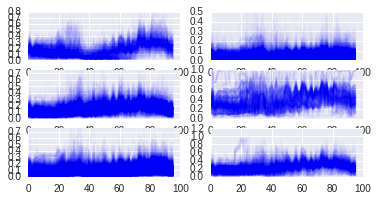

In [131]:
fig = plt.figure()

for x,y in zip(load_data_scaled,prediction):
        if y == 0:
            fig.add_subplot(421)
            plt.plot(x,alpha=0.01,color="blue")
            plt.ylim(0,0.8)
        
for x,y in zip(load_data_scaled,prediction):
        if y == 1:
            fig.add_subplot(422)
            plt.plot(x,alpha=0.007,color="blue")
            plt.ylim(0,0.5)

for x,y in zip(load_data_scaled,prediction):
        if y == 2:
            fig.add_subplot(423)            
            plt.plot(x,alpha=0.01,color="blue")
            plt.ylim(0,0.75)


for x,y in zip(load_data_scaled,prediction):
       if y == 3:
            fig.add_subplot(424)
            plt.plot(x,alpha=0.05,color="blue")
            plt.ylim(0,1)
            
for x,y in zip(load_data_scaled,prediction):
       if y == 4:
            fig.add_subplot(425)
            plt.plot(x,alpha=0.02,color="blue")
            plt.ylim(0,0.75)
for x,y in zip(load_data_scaled,prediction):
       if y == 5:
            fig.add_subplot(426)
            plt.plot(x,alpha=0.02,color="blue")
plt.show()

#for x,y in zip(load_data_scaled,prediction):
#       if y == 6:
#            plt.plot(x,alpha=0.002,color="blue")
#plt.show()

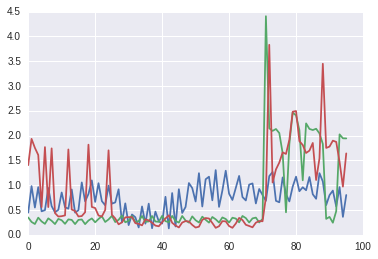

In [35]:
house_101 = df3[df3['id'] == 101]
house_101_day_1 = house_101[(house_101['day_of_month']==1) & (house_101['type_day']==3)]
house_994 = df3[df3['id'] == 994]
house_994_day_1 = house_994[(house_994['day_of_month']==1) & (house_994['type_day']==3)]
house_1350 = df3[df3['id'] == 1350]
house_1350_day_1 = house_1350[(house_1350['day_of_month']==1) & (house_1350['type_day']==3)]
plt.plot(house_101_day_1.energy_use.values)
plt.plot(house_994_day_1.energy_use.values)
plt.plot(house_1350_day_1.energy_use.values)
plt.show()